### Assess Novelty in the Control Dataset

In [143]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from distance import *
from mi_density import *
from utils import *

from pymatgen.core import Structure

import textalloc as ta
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import matplotlib.colors as mcolors
import mpl_style
import matplotlib.gridspec as gridspec

fpath = Path("/Users/andrewf/Library/Fonts/dejavu-sans.condensed.ttf")
mpl.font_manager.fontManager.addfont(fpath)
if fpath.exists():
    # Add the font to the font manager
    mpl.font_manager.fontManager.addfont(str(fpath))

    # Create font properties object
    prop = mpl.font_manager.FontProperties(fname=str(fpath))
    font_name = prop.get_name()

    # Set as default
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = [font_name]

    # Set specific text properties
    # For newer matplotlib versions
    mpl.rc("font", **{"family": "sans-serif", "sans-serif": [font_name]})

    def apply_condensed_font(fig):
        for ax in fig.axes:
            # Apply to all text elements on the axes
            for text in ax.texts:
                text.set_fontproperties(prop)

            # Apply to title and axis labels
            ax.title.set_fontproperties(prop)
            ax.xaxis.label.set_fontproperties(prop)
            ax.yaxis.label.set_fontproperties(prop)

            # Apply to tick labels
            for label in ax.get_xticklabels():
                label.set_fontproperties(prop)
            for label in ax.get_yticklabels():
                label.set_fontproperties(prop)

            # Apply to legend if it exists
            legend = ax.get_legend()
            if legend:
                # Apply to legend title
                if legend.get_title():
                    legend.get_title().set_fontproperties(prop)

                # Apply to legend text
                for text in legend.get_texts():
                    text.set_fontproperties(prop)

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load formulas and structures from dataset folder.

In [152]:
MAT_DB = "control"

# get all cif files in folder
files = [file for file in os.listdir(MAT_DB) if ".cif" in file]

structures = []
formulas = []
space_group_numbers = []
unit_cell_vols = []
for filename in files:
    structure = Structure.from_file(os.path.join(MAT_DB, filename))
    structures.append(structure)
    formulas.append(str(structure.formula))
    try:
        space_group_numbers.append(structure.get_space_group_info()[1]) 
    except:
        space_group_numbers.append(194)
    unit_cell_vols.append(structure.volume)


data = pd.DataFrame({"formula": formulas, "structure": structures, "spacegroup": space_group_numbers, "volume": unit_cell_vols, "filename": files})

In [236]:
# data[data["filename"].str.contains("SiO2")]
# data[data["formula"].str.contains("B")]
data[data["spacegroup"]==221]

,formula,structure,spacegroup,volume,filename,CN4,dists
7,Ti1 Pb1 O3,"[[1.9845245 1.9845245 1.9845245] Ti4+, [0. 0. ...",221,62.525818,[PV] TiPbO3.cif,0.0,2.806541
11,Sr1 Ti1 O3,"[[1.96 1.96 1.96] Sr, [0. 0. 0.] Ti, [1.960000...",221,60.236288,[PV] perovskite STO.cif,0.0,2.771859
20,Cs1 Cl1,"[[0. 0. 0.] Cs, [2.0575 2.0575 2.0575] Cl]",221,69.680221,CsCl.cif,0.0,3.563695
31,Sr1 Cr1 O3,"[[1.946602 1.946602 1.946602] Sr2+, [0. 0. 0.]...",221,59.009439,[PV] SrCrO3.cif,0.0,2.752911


### Load the distance matrices.

Optionally, you can re-generate them from the data.

In [155]:
use_precomputed = True

if use_precomputed:
    lostop_dm = np.load(f"precomputed/{MAT_DB}_lostop_dm.npy")
    elmd_dm = np.load(f"precomputed/{MAT_DB}_elmd_dm.npy")
else:
    lostop_dm = get_lostop_dm(data["structure"].values)
    np.save(f"precomputed/{MAT_DB}_lostop_dm.npy", lostop_dm)

    elmd_dm = get_elmd_dm(data["formula"].values)
    np.save(f"precomputed/{MAT_DB}_elmd_dm.npy", elmd_dm)

### Compute material densities using MI decay profile.

In [169]:
df = pd.DataFrame()
mi_data = {}

for dm, name in zip([lostop_dm, elmd_dm], ["lostop", "elmd"]):

    cutoff, mi_profile = get_MI_profile(dm, n_thresholds=200)

    mi_data[name] = [cutoff, mi_profile]

    print(f"MI cutoff for {name}: {cutoff}")

    df[f'{name}_density'] = compute_mi_density(dm, cutoff, mi_profile)

df['formula'] = data['formula']
df['filename'] = data['filename']
mi_data['lostop'][0] / np.max(lostop_dm)

MI cutoff for lostop: 2.649929285086382
MI cutoff for elmd: 14.54604910552764


0.6532663316582915

In [235]:
# data[data['formula'].str.contains('Ru')] # 54
data[data['formula'].str.contains('Cs')] # 58
# np.argsort(lostop_dm[54])
# lostop_dm[54][np.argsort(lostop_dm[54])]

,formula,structure,spacegroup,volume,filename,CN4,dists
20,Cs1 Cl1,"[[0. 0. 0.] Cs, [2.0575 2.0575 2.0575] Cl]",221,69.680221,CsCl.cif,0.000000,3.563695
52,Cs1 Ba2 Ta3 O10,"[[1.9824 1.9824 7.8696] Cs, [1.9824 1.9824...",123,247.414543,[DJ] CsBa2Ta3O10 dion jacobsen.cif,0.133061,8.115449


In [214]:
from matminer.featurizers.site.fingerprint import CrystalNNFingerprint
cnnf = CrystalNNFingerprint.from_preset("ops")
from tqdm import trange

structure = data.loc[54, "structure"]
print(cnnf.feature_labels()[12])
CN4s = []
for struct in trange(len(data)):

    structure = data.loc[struct, "structure"]
    n_sites = len(structure)
    site_CN4s = []
    for site in range(n_sites):
        feat = cnnf.featurize(structure, site)
        site_CN4s.append(feat[12])
    CN4s.append(np.mean(site_CN4s))

data["CN4"] = CN4s

wt CN_4


100%|██████████| 61/61 [01:11<00:00,  1.17s/it]


In [222]:
len(data[data['CN4']>0.0])/ len(data) 

0.7868852459016393

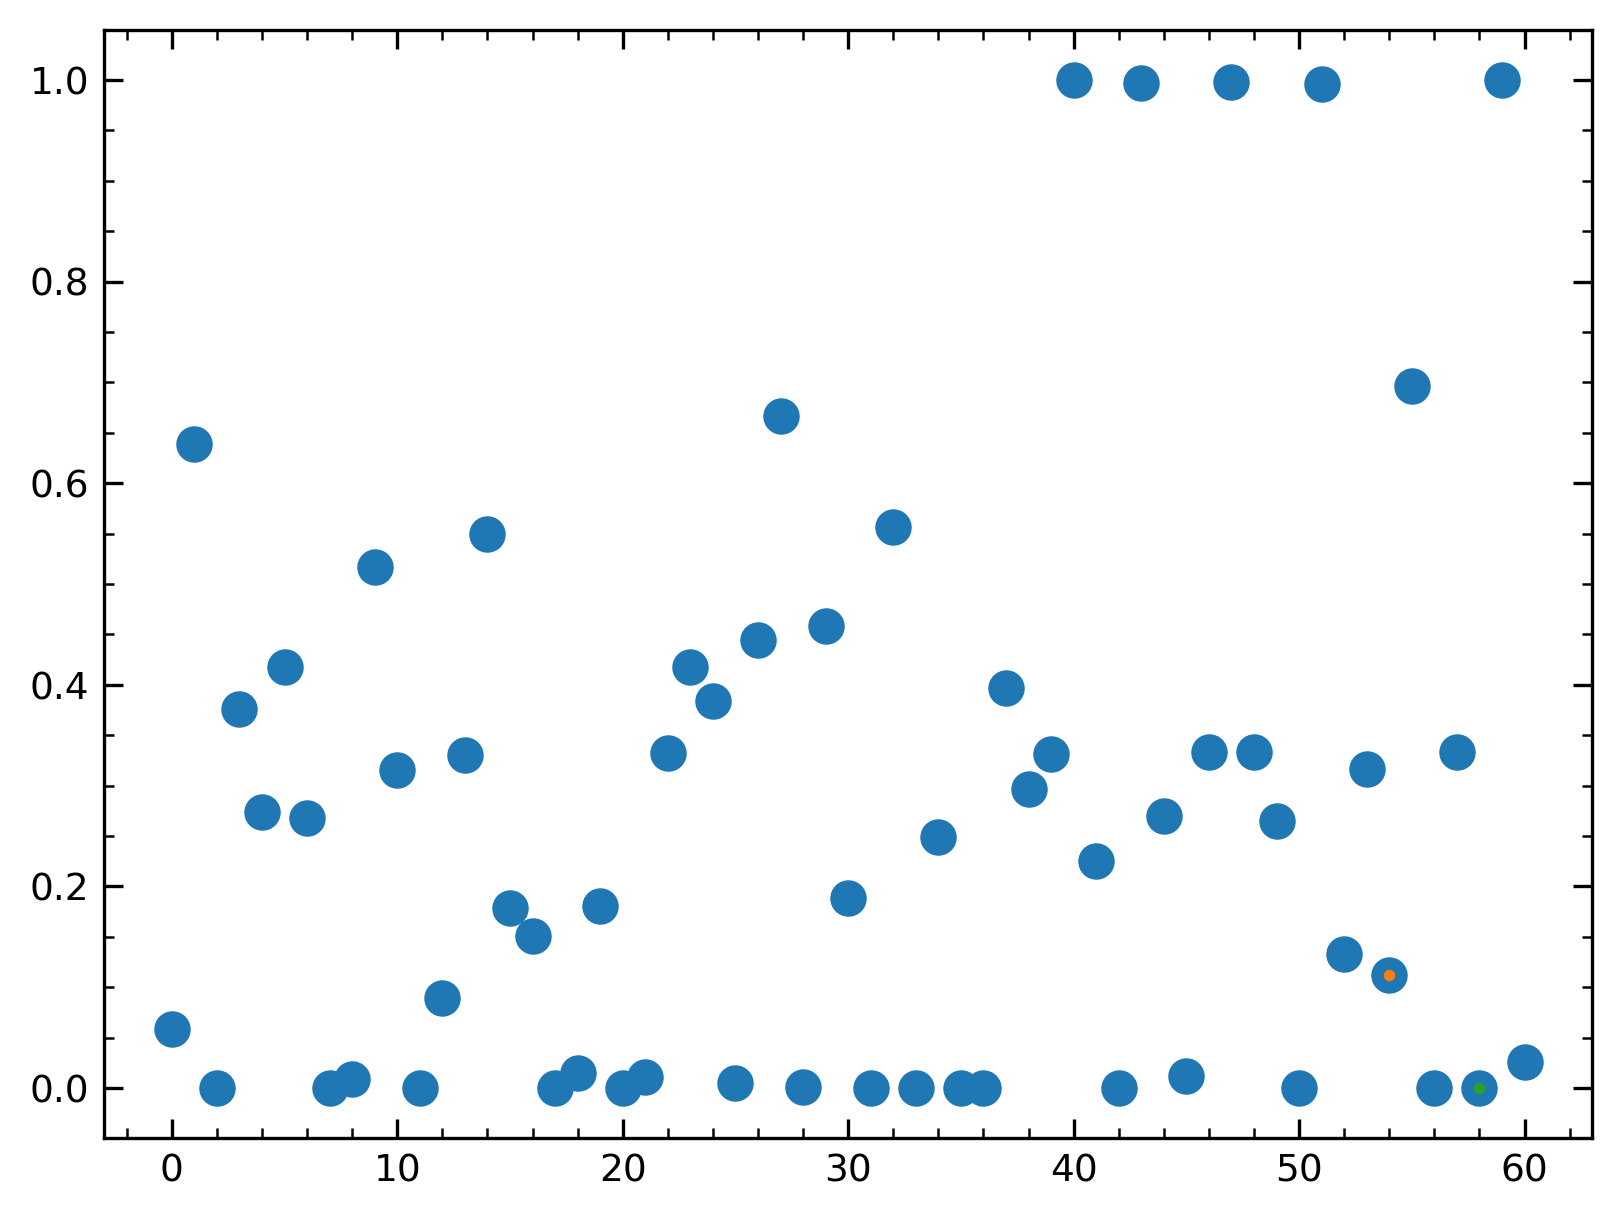

In [223]:
plt.plot(data['CN4'], marker='o', ls='None')
plt.plot([54], data.loc[54, 'CN4'], marker='o', ls='None', ms=2)
plt.plot([58], data.loc[58, 'CN4'], marker='o', ls='None', ms=2)

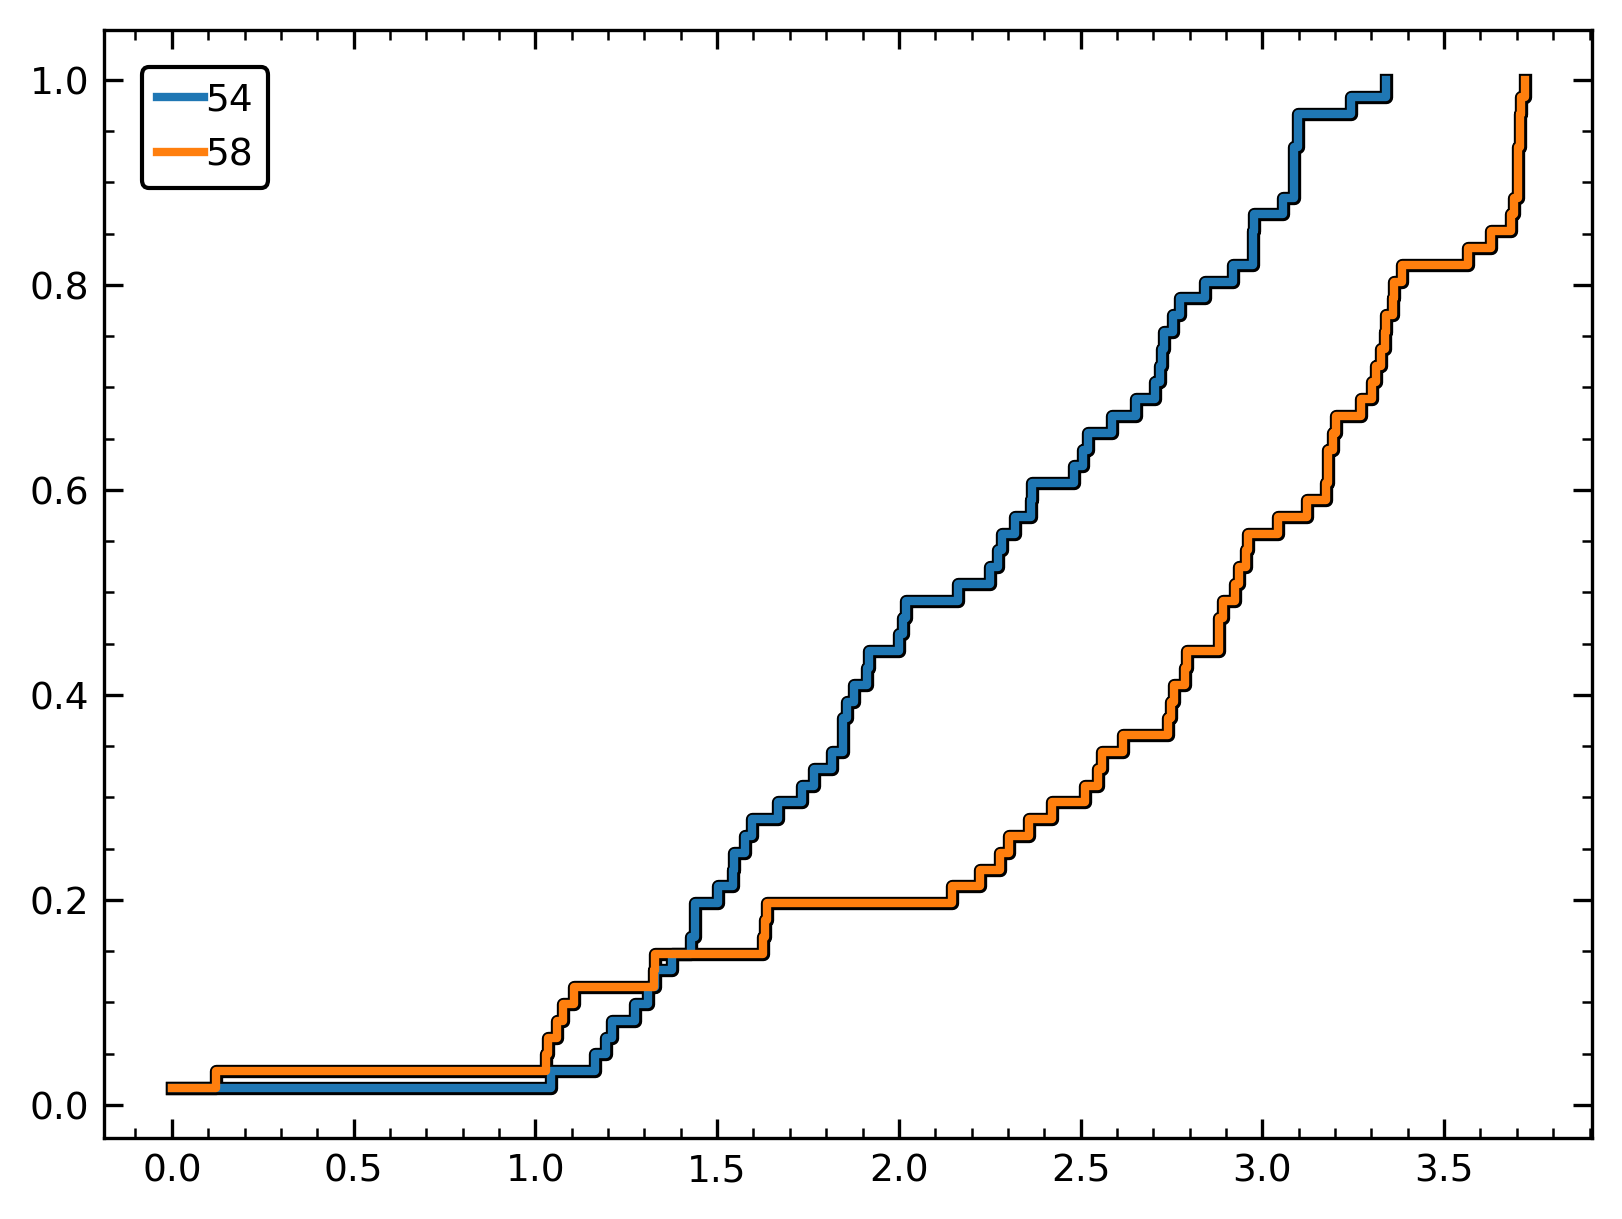

In [202]:
for i, row in enumerate(lostop_dm):
    count = np.ones(row.shape[0])
    cs = np.cumsum(count)/np.sum(count)
    # if i in [52, 50, 64, 1, 3, 55]: # SiO2 indices
    if i in [54, 58]: # SiO2 indices
        plt.step(np.sort(row), cs, color='k', alpha=1, lw=3.2, where='post', zorder=1)
        plt.step(np.sort(row), cs, alpha=1, lw=2,  where='post', zorder=2, label=i)
    else:
        continue
plt.legend()

In [237]:
# idx = 60 # WCl2
idx = 21 # YB4W
idx = 20 # CsCl
print(f"Reference compound formula: {data.loc[idx, 'formula']}")
reference_fp, reference_feats = process_structure(0, data.loc[idx, "structure"])

# Find 10 nearest neighbors
nearest = np.argsort(lostop_dm[idx])[1:20]
# nearest = [58]

# Initialize lists to store differences
feature_diffs = []
neighbor_info = []
neighbor_fps = []

# Compare each neighbor with the reference
for neighbor in nearest:
    # Get neighbor fingerprint
    neighbor_fp, neighbor_feats = process_structure(0, data.loc[neighbor, "structure"])
    neighbor_info.append((neighbor, data.loc[neighbor, "formula"]))
    
    # Calculate absolute differences for each feature
    diffs = np.array(reference_fp) - np.array(neighbor_fp)
    feature_diffs.append(diffs)

# Convert to numpy array for easier manipulation
feature_diffs = np.array(feature_diffs)

# Calculate average difference for each feature across all neighbors
avg_diffs = np.mean(feature_diffs, axis=0)

# Get indices of features sorted by average difference (largest first)
sorted_feature_indices = np.argsort(avg_diffs)[::-1]

# Print the features with the largest differences
print("\nFeatures with largest differences between reference and neighbors:")
print(f"Reference compound {idx}: {data.loc[idx, 'formula']}")

for i, feat_idx in enumerate(sorted_feature_indices[:3]):
    print(f"\n{i+1}. Feature {reference_feats[feat_idx]}: Average difference = {avg_diffs[feat_idx]:.4f}")
    print(f"   Reference value: {reference_fp[feat_idx]}")
    print("   Neighbor values:")
    for j, (neighbor, formula) in enumerate(neighbor_info[:10]):
        print(f"      {formula} (ID: {neighbor}): {neighbor_fp[feat_idx]:.4f} (Diff: {feature_diffs[j][feat_idx]:.4f})")

Reference compound formula: Cs1 Cl1

Features with largest differences between reference and neighbors:
Reference compound 20: Cs1 Cl1

1. Feature mean_body-centered cubic CN_8: Average difference = 0.8611
   Reference value: 0.9396122154877224
   Neighbor values:
      Fe2 (ID: 50): 0.0000 (Diff: 0.3604)
      Li8 O4 (ID: 14): 0.0000 (Diff: 0.6063)
      Ca4 F8 (ID: 27): 0.0000 (Diff: 0.6063)
      Ni2 As2 (ID: 36): 0.0000 (Diff: 0.8155)
      Mn58 (ID: 12): 0.0000 (Diff: 0.9413)
      Zr4 Si4 O16 (ID: 30): 0.0000 (Diff: 0.9465)
      Y4 P4 O16 (ID: 19): 0.0000 (Diff: 0.9490)
      Mn24 Al16 Si24 O96 (ID: 26): 0.0000 (Diff: 0.8601)
      Y4 B16 W4 (ID: 21): 0.0000 (Diff: 0.9386)
      As12 Pb20 Cl4 O48 (ID: 6): 0.0000 (Diff: 0.9366)

2. Feature minimum_body-centered cubic CN_8: Average difference = 0.8563
   Reference value: 0.8792244309754449
   Neighbor values:
      Fe2 (ID: 50): 0.0000 (Diff: 0.3000)
      Li8 O4 (ID: 14): 0.0000 (Diff: 0.8792)
      Ca4 F8 (ID: 27): 0.0000 (Diff:

### Plot MI Profiles for LoStOP and ElMD

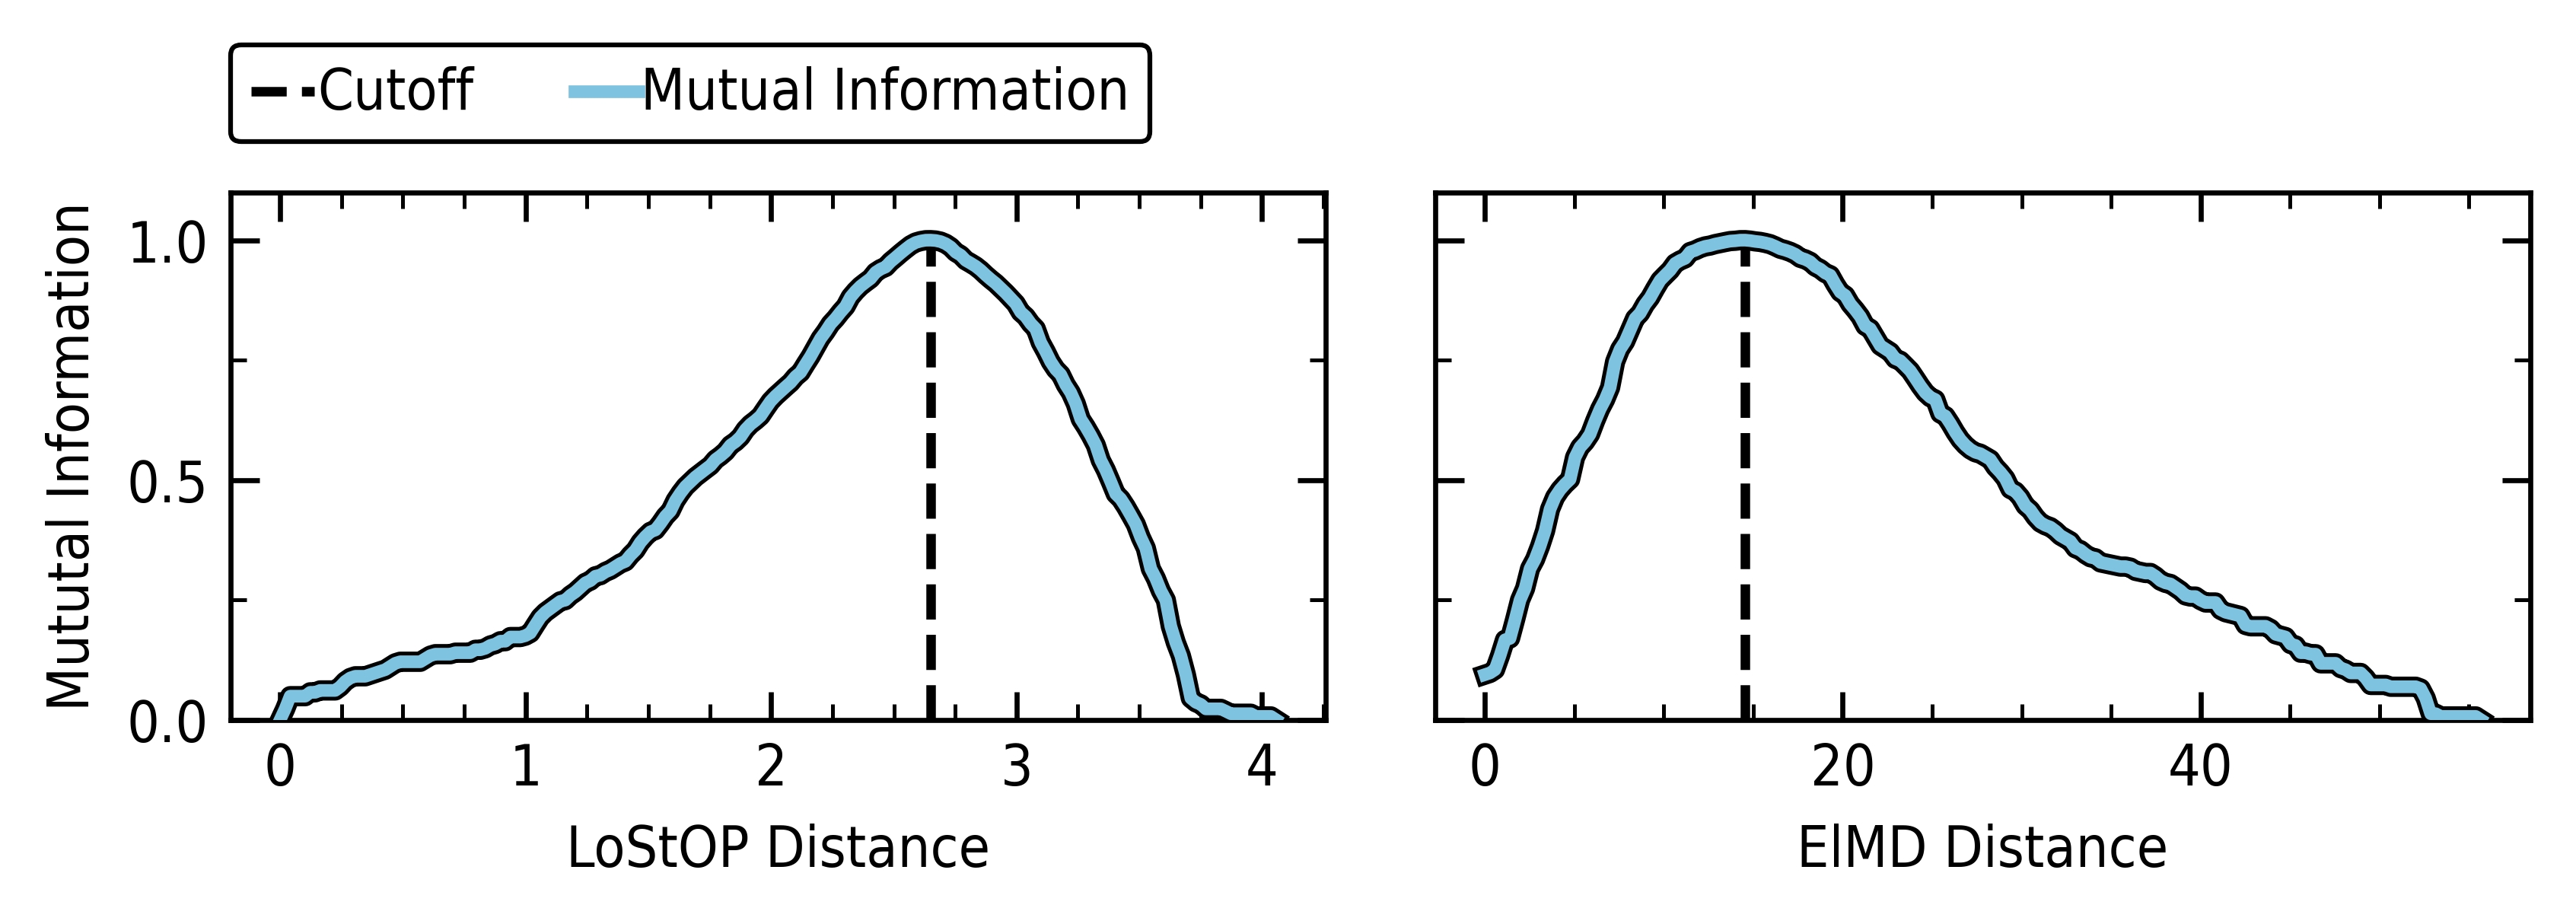

In [159]:
fig, ax = plt.subplots(ncols=2, figsize=(6.5, 1.5), sharey=True, dpi=600)

# adjust the space between the subplots
plt.subplots_adjust(wspace=0.1)

# ax[0].add_patch(Rectangle((0.98, 0.0), 0.55, 1.1, color='k', alpha=0.1, lw=0))
# ax[0].add_patch(Rectangle((1.64, 0.0), 0.425, 1.1, color='k', alpha=0.1, lw=0))
# ax[0].add_patch(Rectangle((2.2, 0.0), 0.565, 1.1, color='k', alpha=0.1, lw=0))

ax[0].vlines(x=mi_data['lostop'][0], ymin=0, ymax=1.0, color='black', lw=1.5, ls='--', label='Cutoff')
ax[0].plot(np.linspace(0, np.max(lostop_dm), 200), mi_data['lostop'][1], zorder=10, color='black', lw=3.2,)
ax[0].plot(np.linspace(0, np.max(lostop_dm), 200), mi_data['lostop'][1], zorder=10, color='#7EC3E0', lw=2, label='Mutual Information')
ax[0].set_yticks([0, 0.5, 1.0])
ax[0].set_ylim(0, 1.1)
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax[0].set_ylabel("Mututal Information")
ax[0].set_xlabel("LoStOP Distance")

# ax[1].add_patch(Rectangle((7.35, 0.0), 13.25, 1.1, color='k', alpha=0.1, lw=0))
# ax[1].add_patch(Rectangle((22.9, 0.0), 3.8, 1.1, color='k', alpha=0.1, lw=0))
ax[1].vlines(x=mi_data['elmd'][0], ymin=0, ymax=1, color='black', lw=1.5, ls='--', label='Cutoff')
ax[1].plot(np.linspace(0, np.max(elmd_dm), 200), mi_data['elmd'][1], zorder=10, color='black', lw=3.2,)
ax[1].plot(np.linspace(0, np.max(elmd_dm), 200), mi_data['elmd'][1], zorder=10, color='#7EC3E0', lw=2, label='Mutual Information')
# ax[1].set_xlim(None, 27.5)
ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax[1].set_xlabel("ElMD Distance")

legend = ax[0].legend(loc='lower center', fontsize=8, frameon=True, framealpha=1.0, labelspacing=0.25, bbox_to_anchor=(0.42, 1.0), ncol=2)
legend.get_frame().set_linewidth(0.75)


apply_condensed_font(fig)

plt.show()

### Plot material densities along chemical and structural axes.

Note that the publication figure was adjusted post-hoc for visual clarity due to positioning issues with the `textalloc` library.

In [165]:
# da[data['filename'].str.contains('SiC')] # 40, 43, 47, 51
# df[df['filename'].str.contains('SiC')] # 13, 22, 39, 46, 49, 57
df[df['filename'].str.contains('ClO')] 


,lostop_density,elmd_density,formula,filename
6,16.768838,14.406708,As12 Pb20 Cl4 O48,As3Pb5ClO12.cif


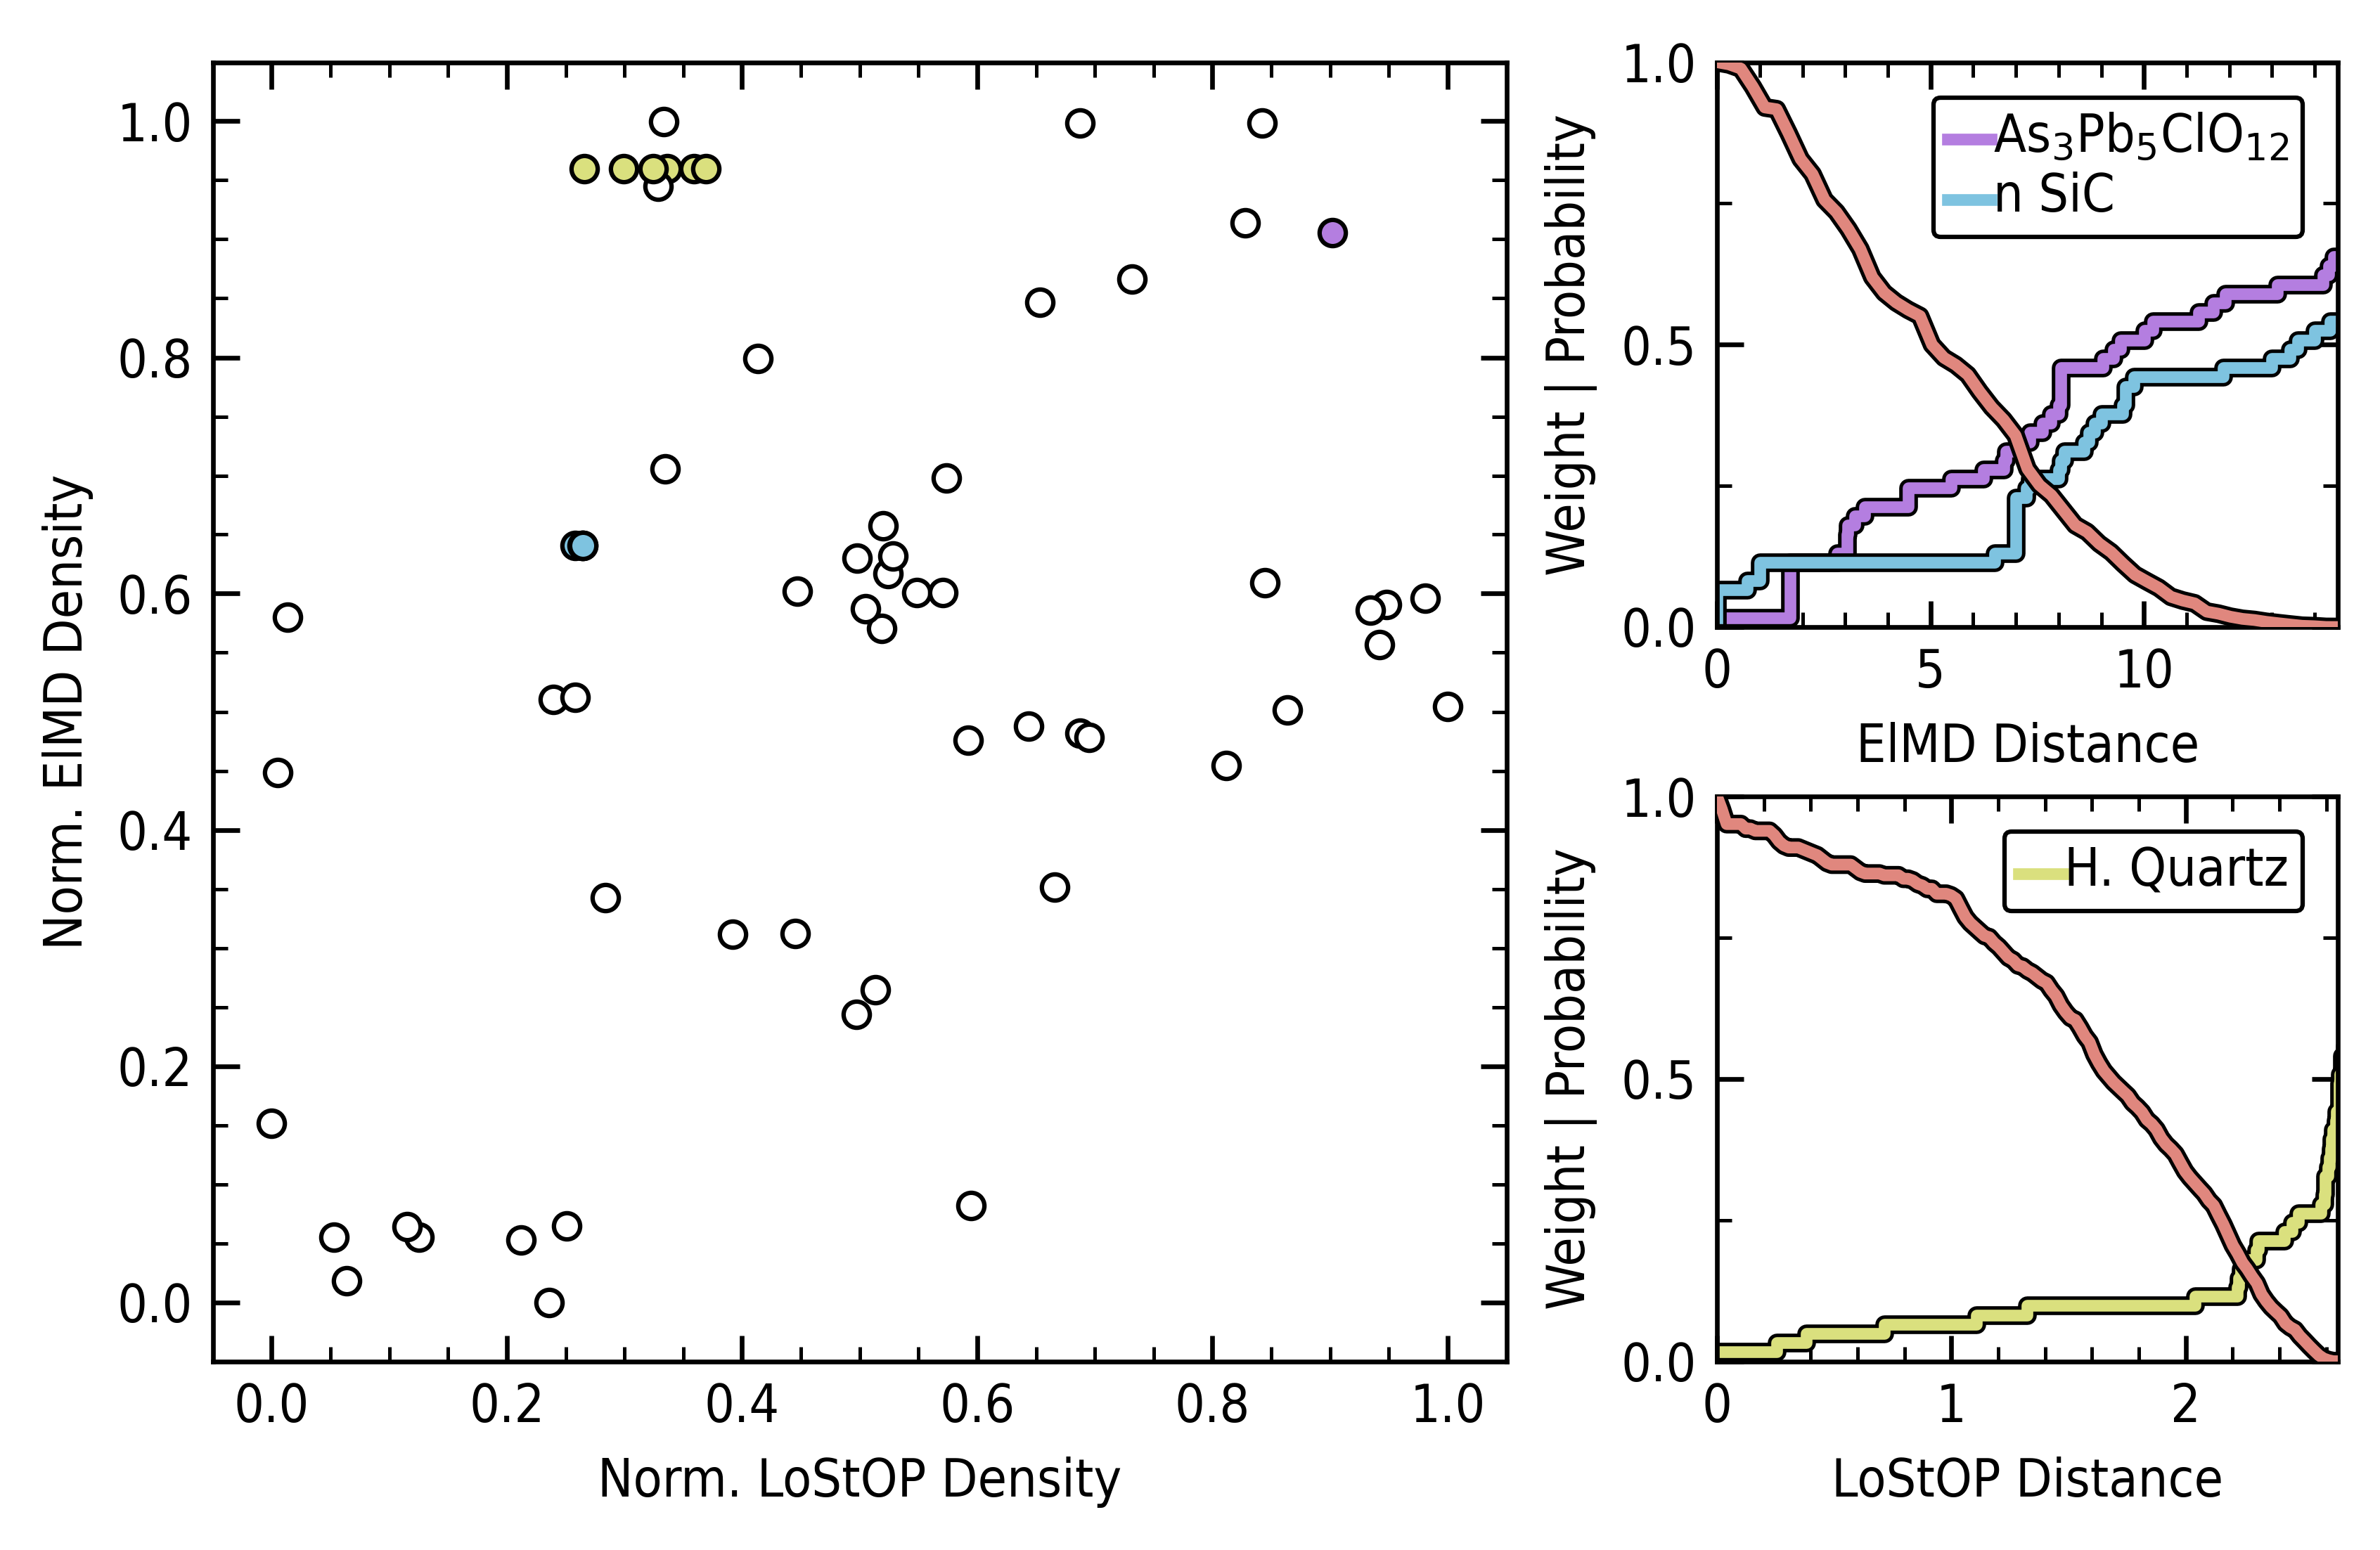

In [239]:
scaled_df = df.copy()

# scale the scaled_df
scaled_df[['lostop_density', 'elmd_density']] = MinMaxScaler().fit_transform(scaled_df[['lostop_density', 'elmd_density']])

p_idx = is_pareto_efficient(scaled_df[['lostop_density', 'elmd_density']].values, return_mask=False)
# pareto_labels = [labels[i] for i in p_idx]
pareto_x = scaled_df['lostop_density'].loc[p_idx]
pareto_y = scaled_df['elmd_density'].loc[p_idx]
pareto_x, pareto_y = zip(*sorted(zip(pareto_x, pareto_y), key=lambda pair: pair[1]))


fig = plt.figure(figsize=(6.5, 4), dpi=600)
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=(1, 0.48), hspace=0.3, wspace=0.22)

main_scatter = fig.add_subplot(gs[:, 0])
# main_scatter.set_aspect('equal')

# main_scatter.plot(pareto_x, pareto_y, color='k', lw=1.5, ls='-', marker='None', label='Pareto Front')
for i, row in enumerate(range(len(scaled_df))):
    main_scatter.scatter(
        scaled_df['lostop_density'].loc[i],
        scaled_df['elmd_density'].loc[i], 
        s=20, 
        zorder=9, 
        lw=0.75, 
        ec='k', 
        fc="#7EC3E0" if i in [40, 43, 47, 51] else "#B47EE0" if i in [6] else "#DAE07E" if i in [13, 22, 39, 46, 49, 57] else "white")

main_scatter.set_xlabel("Norm. LoStOP Density")
main_scatter.set_ylabel("Norm. ElMD Density")

mask = np.linspace(0, np.max(elmd_dm), 200) <= mi_data['elmd'][0]
profile = mi_data['elmd'][1][mask]-np.min(mi_data['elmd'][1][mask])

sic_plot = fig.add_subplot(gs[0, 1])
sic_plot.plot(np.linspace(0, np.max(elmd_dm), 200)[mask], 1-profile/np.max(profile), color='k', lw=3.2, zorder=4)
sic_plot.plot(np.linspace(0, np.max(elmd_dm), 200)[mask], 1-profile/np.max(profile), color='#E0877E', lw=2, zorder=5)#, label='Decay Weight')

for i, row in enumerate(elmd_dm):
    count = np.ones(row.shape[0])
    cs = np.cumsum(count)/np.sum(count)
    # if i in [46, 49, 54, 58]: # SiC indices
    if i in [40]: # SiC indices
        sic_plot.step(np.sort(row), cs, color='k', alpha=1, lw=3.2, where='post')
        sic_plot.step(np.sort(row), cs, color='#7EC3E0', alpha=1, lw=2, where='post', label='n SiC')
    elif i in [6]: # As3Pb5ClO12 index
        sic_plot.step(np.sort(row), cs, color='k', alpha=1, lw=3.2, where='post')
        sic_plot.step(np.sort(row), cs, color='#B47EE0', alpha=1, lw=2, where='post', label='As$_3$Pb$_5$ClO$_{12}$')
    else:
        continue

sic_plot.set_xlim(0, mi_data['elmd'][0])
sic_plot.set_ylim(0, 1.0)
sic_plot.set_yticks([0, 0.5, 1.0])
sic_plot.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))

sic_plot.set_xlabel("ElMD Distance")
sic_plot.set_ylabel("Weight | Probability")

sic_legend = sic_plot.legend(loc='upper right', fontsize=6, frameon=True, framealpha=1.0, labelspacing=0.25)
sic_legend.get_frame().set_linewidth(0.75)

sio_plot = fig.add_subplot(gs[1, 1])
sio_plot.plot(np.linspace(0, np.max(lostop_dm), 200), 1-mi_data['lostop'][1]/mi_data['lostop'][1].max(), color='k', lw=3.2, zorder=3)
sio_plot.plot(np.linspace(0, np.max(lostop_dm), 200), 1-mi_data['lostop'][1]/mi_data['lostop'][1].max(), color='#E0877E', lw=2, zorder=4)#, label='Decay Weight')


for i, row in enumerate(lostop_dm):
    count = np.ones(row.shape[0])
    cs = np.cumsum(count)/np.sum(count)
    # if i in [52, 50, 64, 1, 3, 55]: # SiO2 indices
    if i in [57]: # SiO2 indices
        sio_plot.step(np.sort(row), cs, color='k', alpha=1, lw=3.2, where='post', zorder=1)
        sio_plot.step(np.sort(row), cs, color='#DAE07E', alpha=1, lw=2,  where='post', zorder=2, label='H. Quartz')
    else:
        continue

sio_plot.set_xlim(0, mi_data['lostop'][0])
sio_plot.set_ylim(0, 1.0)
sio_plot.set_yticks([0, 0.5, 1.0])
sio_plot.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))

sio_plot.set_xlabel("LoStOP Distance")
sio_plot.set_ylabel("Weight | Probability")

sio_legend = sio_plot.legend(loc='upper right', fontsize=6, frameon=True, framealpha=1.0, labelspacing=0.25)
sio_legend.get_frame().set_linewidth(0.75)

apply_condensed_font(fig)

plt.show()

In [167]:
scaled_df.to_clipboard()

In [70]:
print(scaled_df[scaled_df['formula'].str.contains('O')]['elmd_density'].median())
print(scaled_df[~scaled_df['formula'].str.contains('O')]['elmd_density'].median())

0.6722507616542847
0.44316470744816183


In [46]:
scaled_df[scaled_df['formula'].str.contains("Cl")] # 61 SRO 65 STO


# fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), dpi=500)

# ax.plot(np.linspace(0, np.max(lostop_dm), 200), 1-mi_data['lostop'][1]/mi_data['lostop'][1].max(), color='k', lw=3.2, zorder=3)
# ax.plot(np.linspace(0, np.max(lostop_dm), 200), 1-mi_data['lostop'][1]/mi_data['lostop'][1].max(), color='#E0877E', lw=2, zorder=4)#, label='Decay Weight')


# for i, row in enumerate(lostop_dm):
#     count = np.ones(row.shape[0])
#     cs = np.cumsum(count)/np.sum(count)
#     # if i in [46, 49, 54, 58]: # SiC indices
#     if i in [61]: # SiC indices
#         ax.step(np.sort(row), cs, color='k', alpha=1, lw=3.2, where='post')
#         ax.step(np.sort(row), cs, color='#7EC3E0', alpha=1, lw=2, where='post', label='SRO')
#     elif i in [65]: # As3Pb5ClO12 index
#         ax.step(np.sort(row), cs, color='k', alpha=1, lw=3.2, where='post')
#         ax.step(np.sort(row), cs, color='#B47EE0', alpha=1, lw=2, where='post', label='STO')
#     else:
#         continue

# plt.legend()
# plt.show()

,lostop_density,elmd_density,formula
5,0.597798,0.051189,Na4 Cl4
9,0.837330,0.891333,As12 Pb20 Cl4 O48
26,0.078404,0.051189,Cs1 Cl1
67,0.000000,0.169530,W24 Cl48


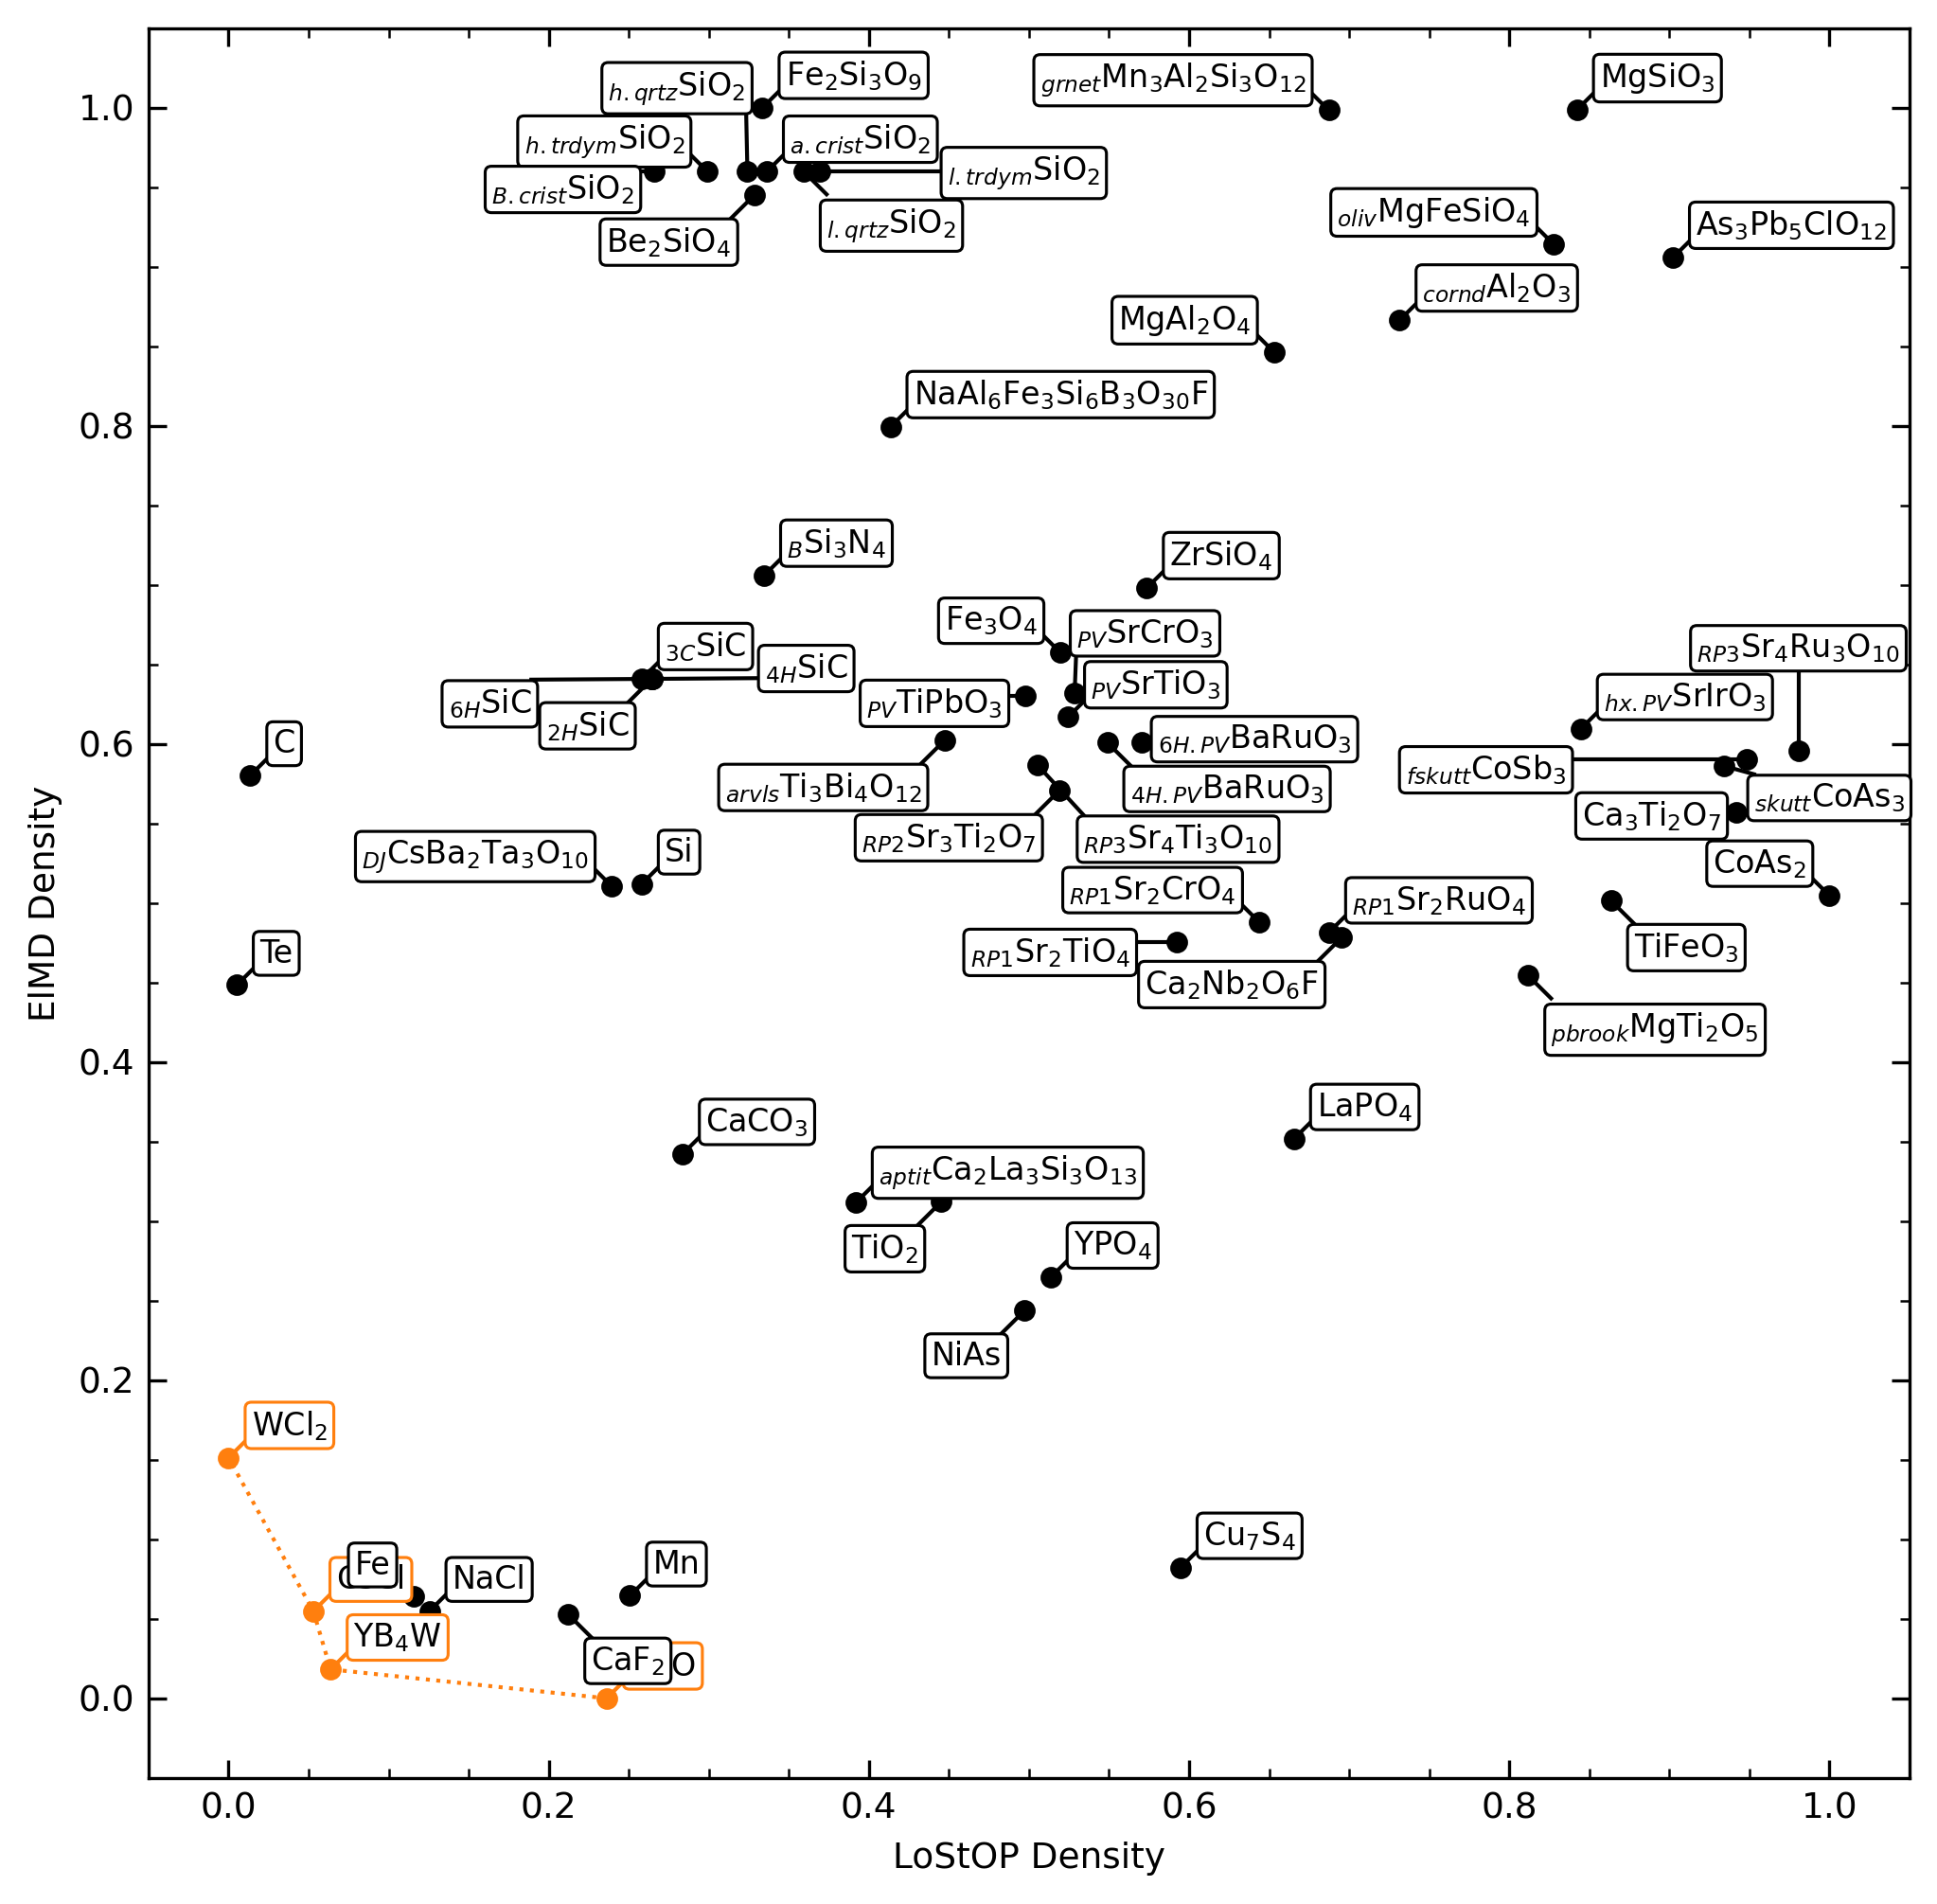

In [168]:
scaled_df = df.copy()

# scale the scaled_df
scaled_df[['lostop_density', 'elmd_density']] = MinMaxScaler().fit_transform(scaled_df[['lostop_density', 'elmd_density']])

# get some nice formula labels
labels = [reduce_single_formula(formula) for formula in scaled_df['formula'].values]
for i, label in enumerate(labels):
    if "[" in data['filename'].values[i]:
        labels[i] = "$_{" + data['filename'].values[i].split(']')[0].split('[')[1] + "}$" + str(label)

fig, ax = plt.subplots(figsize=(8, 8), dpi=300)

# find the pareto optimal points and plot the front
p_idx = is_pareto_efficient(scaled_df[['lostop_density', 'elmd_density']].values, return_mask=False)
pareto_labels = [labels[i] for i in p_idx]
pareto_x = scaled_df['lostop_density'].loc[p_idx]
pareto_y = scaled_df['elmd_density'].loc[p_idx]
pareto_x, pareto_y = zip(*sorted(zip(pareto_x, pareto_y), key=lambda pair: pair[1]))
ax.plot(pareto_x, pareto_y, color='C1', lw=1, ls=':', marker='None')

# plot points with custom colors for pareto points
for i in range(len(scaled_df)):
    ax.scatter(
        scaled_df['lostop_density'].iloc[i],
        scaled_df['elmd_density'].iloc[i],
        color='C1' if i in p_idx else 'k',
        s=20,
        zorder=10,
    )

# label pareto points
ta.allocate(ax,
            x=scaled_df['lostop_density'].loc[p_idx],
            y=scaled_df['elmd_density'].loc[p_idx],
            text_list=pareto_labels,
            x_scatter=scaled_df['lostop_density'].loc[p_idx].values,
            y_scatter=scaled_df['elmd_density'].loc[p_idx].values,
            x_lines=[pareto_x],
            y_lines=[pareto_y],
            textsize=8,
            nbr_candidates=10000,
            linecolor='C1',
            avoid_crossing_label_lines=True,
            avoid_label_lines_overlap=True,
            bbox=dict(boxstyle="round", fc="w", ec="C1", pad=0.2, lw=0.75),
            zorder=15,
            )

# drop p_idx indices from scaled_df and labels
scaled_df = scaled_df.drop(scaled_df.index[p_idx])
labels = [label for i, label in enumerate(labels) if i not in p_idx]

ta.allocate(ax,
            x=scaled_df['lostop_density'],
            y=scaled_df['elmd_density'],
            text_list=labels,
            x_scatter=scaled_df['lostop_density'].values,
            y_scatter=scaled_df['elmd_density'].values,
            x_lines=[pareto_x],
            y_lines=[pareto_y],
            textsize=8,
            nbr_candidates=10000,
            linecolor='k',
            avoid_crossing_label_lines=True,
            avoid_label_lines_overlap=True,
            bbox=dict(boxstyle="round", fc="w", ec="k", pad=0.2, lw=0.75),
            zorder=15,
            )

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

# Set labels
ax.set_xlabel("LoStOP Density")
ax.set_ylabel("ElMD Density")
plt.show()